In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# import data

In [2]:
datafolder_path = Path ("../data/")
raw_csv = datafolder_path / "raw/spectra_batch_250205.csv"
spectra_df = pd.read_csv(raw_csv)

label_csv = datafolder_path / "processed/label.csv"
info_df = pd.read_csv(label_csv)

spectra_df.shape, info_df.shape

((3354, 31), (661, 23))

In [3]:
spectra_df.head()

,lot_id,active,analyzer_id,company_id,dark_ref_data,dark_ref_scan_time,date_scanned,detector_temp,frame_data,id,integration_time,location_id,name,raw_data,scope_data,spectrometer_temp,user_id,white_ref_data,white_ref_scan_time,calc_data_mini,dark_ref_data_mini,white_ref_data_mini,scope_data_mini,calc_data_neo,dark_ref_data_neo,white_ref_data_neo,scope_data_neo,version,healthy,specimen_id,lot_name
0,69163,1,72,1243,"[120.823625, 120.366875, 114.9684375, 119.5198...",1713792037,1713794137,32.6,False,420525,2.5,NaN,69163-532542,"[{""wavelength"": 336.2986755371094, ""reflectanc...","[121.1013125, 120.2069375, 115.22925, 119.7597...",36.75,1821,"[120.32325, 119.2214375, 114.7174375, 118.6095...",1713792089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420525,MRKU8144625
1,69163,1,72,1243,"[120.823625, 120.366875, 114.9684375, 119.5198...",1713792037,1713794159,32.6,False,420526,2.5,NaN,69163-929581,"[{""wavelength"": 336.2986755371094, ""reflectanc...","[121.3424375, 120.815125, 115.9264375, 120.308...",36.75,1821,"[120.32325, 119.2214375, 114.7174375, 118.6095...",1713792089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420526,MRKU8144625
2,69163,1,72,1243,"[120.823625, 120.366875, 114.9684375, 119.5198...",1713792037,1713794178,32.6,False,420527,2.5,NaN,69163-408774,"[{""wavelength"": 336.2986755371094, ""reflectanc...","[120.848625, 120.09775, 115.2720625, 119.53475...",37.00,1821,"[120.32325, 119.2214375, 114.7174375, 118.6095...",1713792089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420527,MRKU8144625
3,69163,1,72,1243,"[120.823625, 120.366875, 114.9684375, 119.5198...",1713792037,1713794195,32.6,False,420528,2.5,NaN,69163-968656,"[{""wavelength"": 336.2986755371094, ""reflectanc...","[121.3093125, 120.5825, 115.596875, 120.0875, ...",37.00,1821,"[120.32325, 119.2214375, 114.7174375, 118.6095...",1713792089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420528,MRKU8144625
4,69163,1,72,1243,"[120.823625, 120.366875, 114.9684375, 119.5198...",1713792037,1713794214,32.6,False,420529,2.5,NaN,69163-621945,"[{""wavelength"": 336.2986755371094, ""reflectanc...","[121.677625, 120.8741875, 116.230625, 120.2780...",37.00,1821,"[120.32325, 119.2214375, 114.7174375, 118.6095...",1713792089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420529,MRKU8144625


In [4]:
info_df.head()

,lot_id,lot_name,Acetic,Ash,Astringent,Bitter,Brown Fruit,Cacao (Chocolate),Carbon,Deodorization Level,Earthy,Fishy,Heated Fat (Oil),Musty,Oxidized (Old Butter-Stale-Cardboard),Painty (Solvent-Chemical),Petroleum (Motor Oil-Rubber),Putrid,Sensory Result,Smoky,Sour,Straw (Hay),Sensory Value
0,69163,MRKU8144625,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67
1,69165,PCIU1703142,Absent,Present,Absent,Present,Absent,Present,Present,Non-Deodorized,Absent,Present,Present,Absent,Present,Absent,Absent,Absent,Fail,Present,Present,Present,1.80
2,69166,MSKU4082229,Absent,Present,Absent,Absent,Absent,Absent,Absent,Non-Deodorized,Absent,Absent,Absent,Present,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.83
3,69169,HASU1260204,Absent,Absent,Absent,Present,Absent,Present,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Absent,Absent,Absent,Pass,Absent,Absent,Absent,0.25
4,69170,TRHU2677983,Absent,Absent,Absent,Present,Absent,Present,Absent,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Absent,Absent,Absent,Pass,Absent,Absent,Present,0.17


# train test split random

In [ ]:
# # random split
# def train_test_split_lot_level (label_df, test_size=0.1):
#     label = label_df.set_index('lot_id')
#     sorted_idx = label.index.unique()
#     train_label, test_label = train_test_split(label.loc[sorted_idx], 
#                                                  test_size=test_size, 
#                                                  stratify=label.loc[sorted_idx]['ABOVE_BELOW_5pct_Dwarf'],
#                                                  shuffle=True, 
#                                                  random_state=42)
    
#     train_idx = train_label.index.sort_values()
#     test_idx = test_label.index.sort_values()

#     return train_idx, test_idx

# train_index, test_index = train_test_split_lot_level(label_df)
# print(train_index, test_index)

# #is test_idx in train_idx
# print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


# train-test split multilabel stratify random

In [5]:
# Convert DataFrame to NumPy array
label_df_encoded = info_df.copy(deep=True).reset_index().set_index('lot_id').drop(columns=['lot_name','Sensory Result'])

X = label_df_encoded.index.values.reshape(-1, 1)
# print("Features:\n", X)

#encode label_df
encoder = LabelEncoder()
for col in label_df_encoded.columns:
    label_df_encoded[col] = encoder.fit_transform(label_df_encoded[col])
y = label_df_encoded.values  # Multi-label binary targets

# Split dataset into train and test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

train_idx = X_train.flatten()
test_idx = X_test.flatten()

print(train_idx.shape, test_idx.shape)
print(f'train and test is disjoint: {set(train_idx).isdisjoint(set(test_idx))}')


(527,) (134,)
train and test is disjoint: True


# split by time

In [ ]:
# # train index is where replicate is not s2, test index is where replicate is s2
# label_df_temp = label_df.copy()
# label_df_temp = label_df_temp.set_index('lot_id')
# # train_index = label_df_temp[label_df_temp['replicate']!='s2'].index
# train_index = label_df_temp[~label_df_temp['replicate'].str.contains('s')].index
# test_index = label_df_temp[label_df_temp['replicate'].str.contains('s')].index

# print(train_index, "\n",test_index)

# #is test_idx in train_idx
# print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


In [6]:
info_df_copy = info_df.copy(deep=True).set_index('lot_id').drop(columns=['lot_name'])
info_df_copy["train_test"] = np.where(info_df_copy.index.isin(train_idx), 'train', 'test')
info_df_copy.head()

,Acetic,Ash,Astringent,Bitter,Brown Fruit,Cacao (Chocolate),Carbon,Deodorization Level,Earthy,Fishy,Heated Fat (Oil),Musty,Oxidized (Old Butter-Stale-Cardboard),Painty (Solvent-Chemical),Petroleum (Motor Oil-Rubber),Putrid,Sensory Result,Smoky,Sour,Straw (Hay),Sensory Value,train_test
lot_id,,,,,,,,,,,,,,,,,,,,,,
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67,train
69165,Absent,Present,Absent,Present,Absent,Present,Present,Non-Deodorized,Absent,Present,Present,Absent,Present,Absent,Absent,Absent,Fail,Present,Present,Present,1.80,test
69166,Absent,Present,Absent,Absent,Absent,Absent,Absent,Non-Deodorized,Absent,Absent,Absent,Present,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.83,test
69169,Absent,Absent,Absent,Present,Absent,Present,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Absent,Absent,Absent,Pass,Absent,Absent,Absent,0.25,train
69170,Absent,Absent,Absent,Present,Absent,Present,Absent,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Absent,Absent,Absent,Pass,Absent,Absent,Present,0.17,train


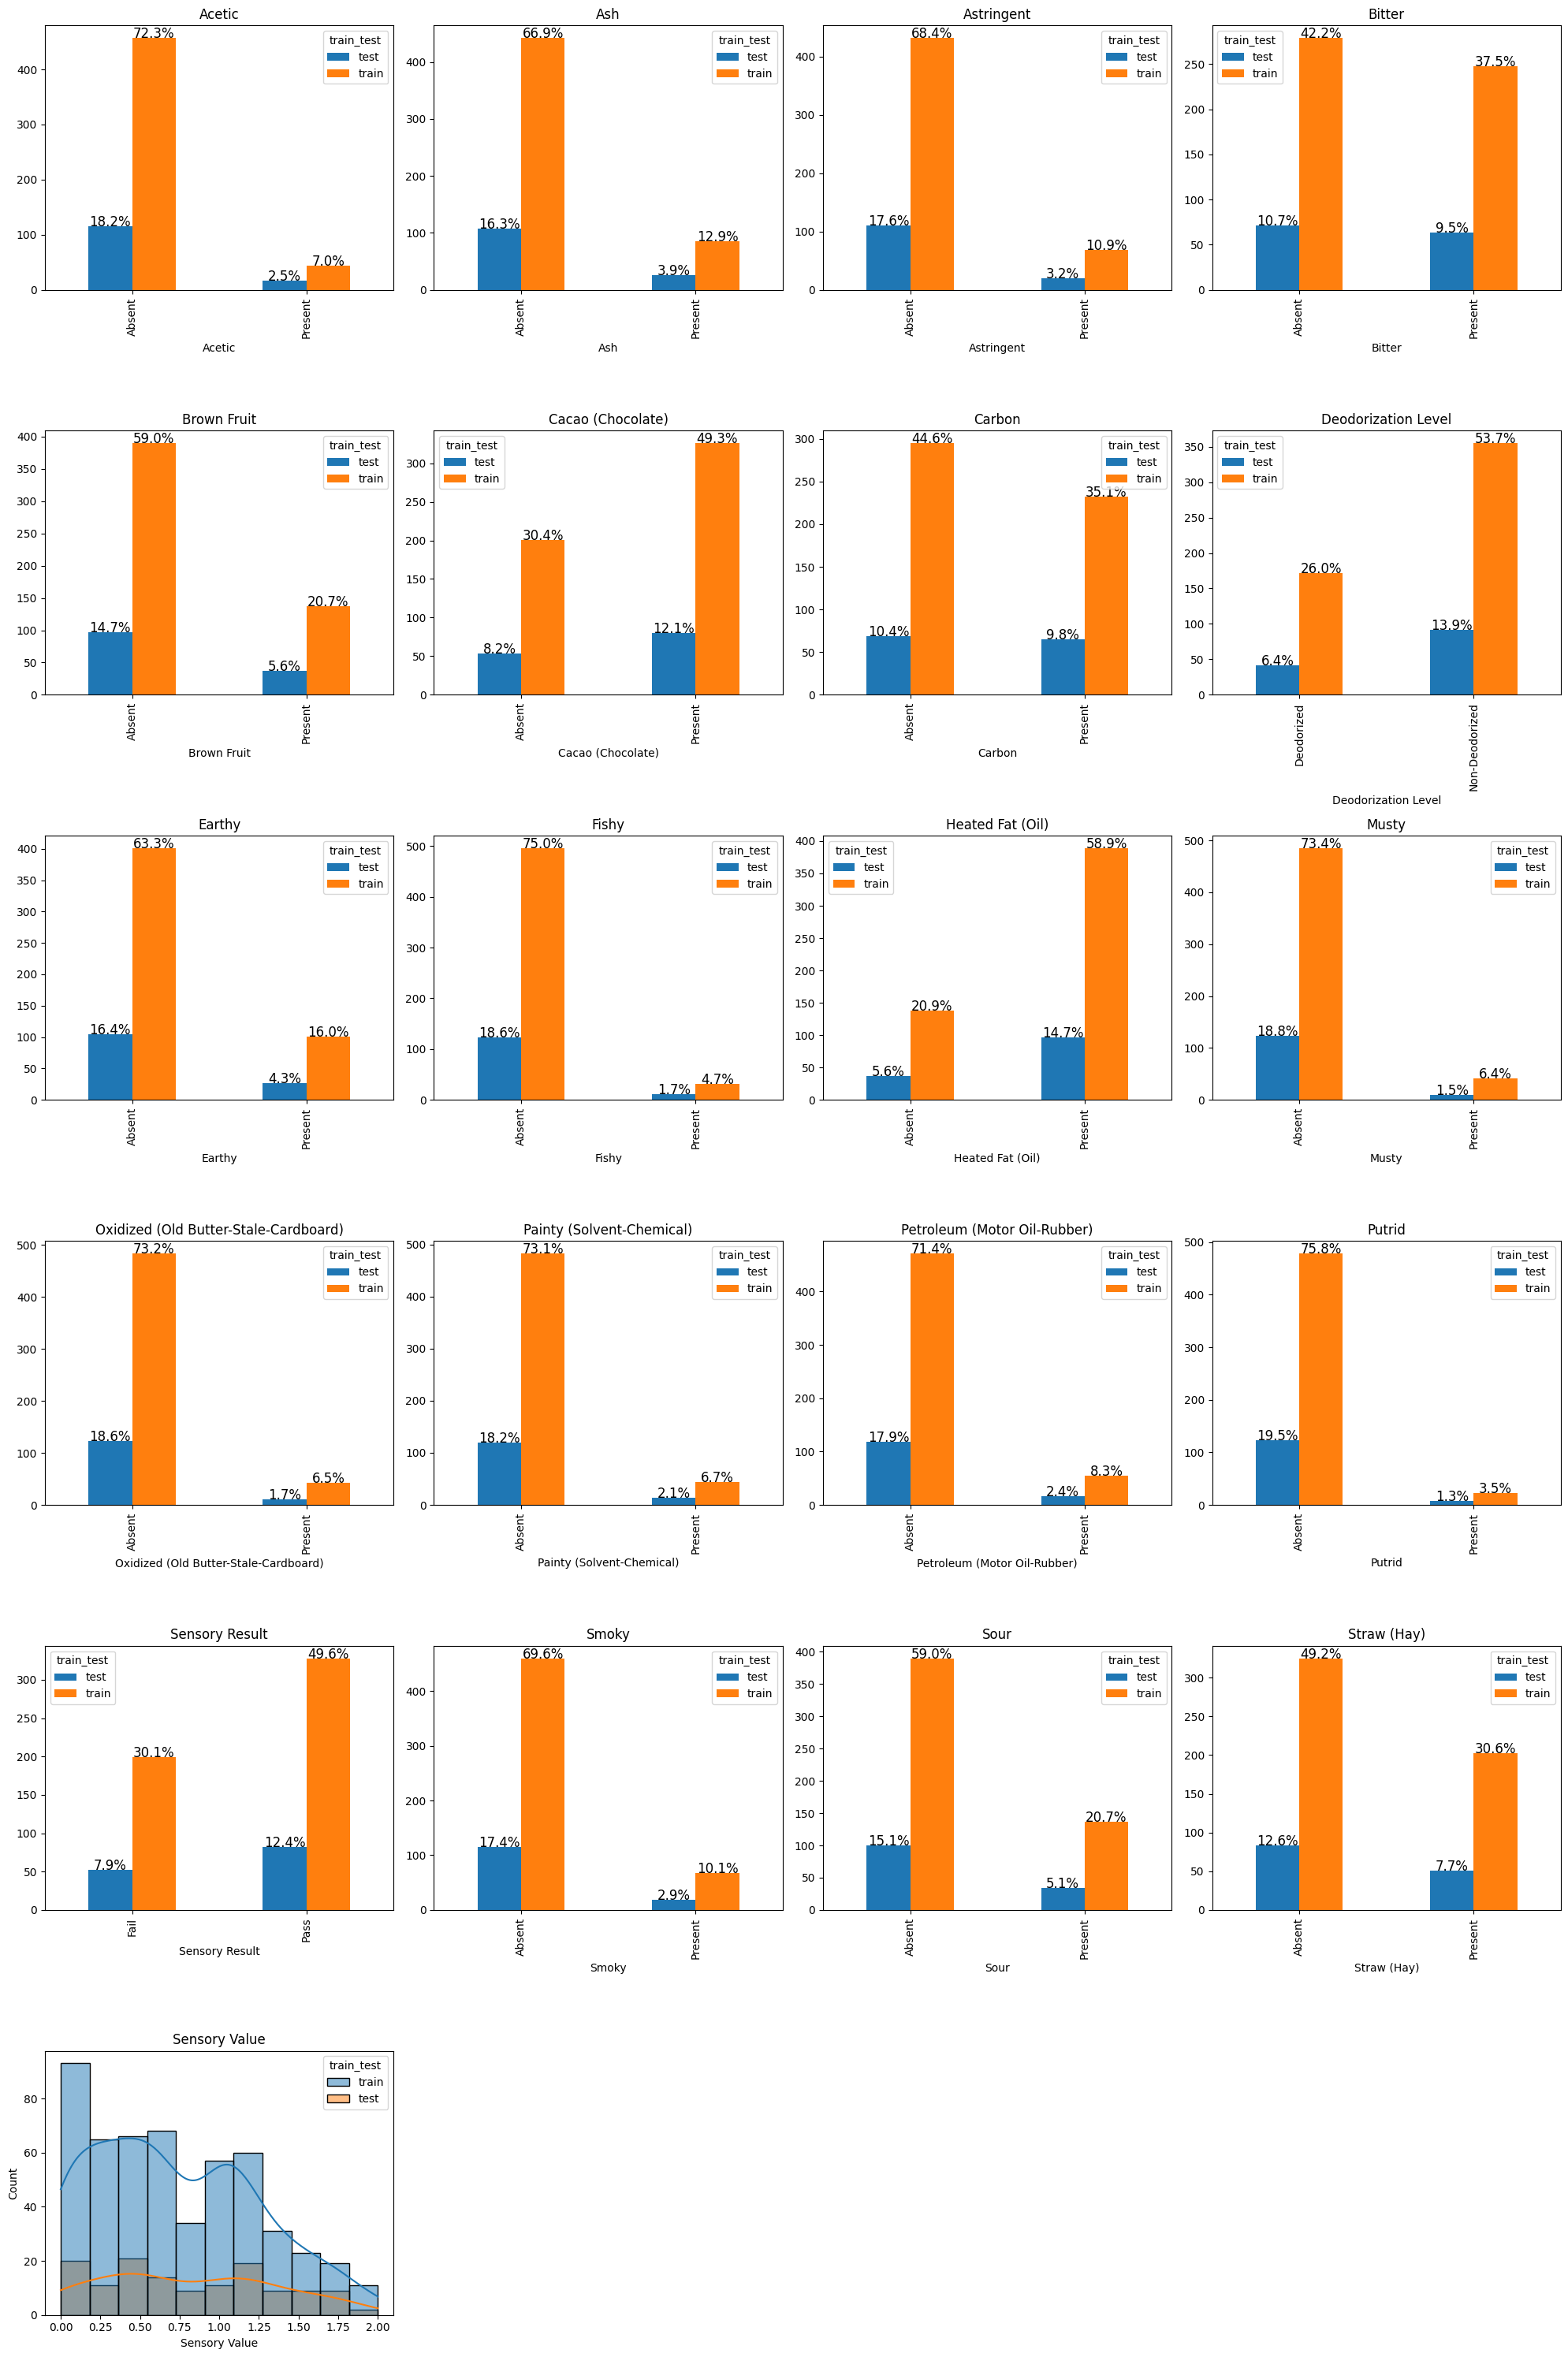

In [7]:
num_cols = len(info_df_copy.columns) - 1  # Exclude 'train_test'
rows = int(np.ceil(num_cols / 4))  # Calculate required rows dynamically
fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

# Flatten ax to avoid indexing issues when rows < 4
ax = ax.flatten()

for i, col in enumerate(info_df_copy.drop(columns=['train_test']).columns):
    if col == 'train_test':  # Skip train_test column itself
        continue
    
    if info_df_copy[col].dtype == 'float64':
        sns.histplot(data=info_df_copy, x=col, hue='train_test', ax=ax[i], kde=True)
        ax[i].set_title(f'{col}')
    else:
        value_counts = info_df_copy.groupby([col, 'train_test']).size().unstack(fill_value=0)
        total = value_counts.sum().sum()  # Get total count for percentage
        value_counts.plot(kind='bar', stacked=False, ax=ax[i])
        ax[i].set_title(f'{col}')
        
        # Add percentage labels
        for p in ax[i].patches:
            height = p.get_height()
            if height > 0:
                ax[i].text(
                    p.get_x() + p.get_width() / 2.,
                    height,
                    f'{(height / total) * 100:.1f}%',
                    ha='center',
                    fontsize=12,
                    color='black'
                )

# Hide any unused subplots
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


# preprocess

In [8]:
raw_df, label_df = preprocess(spectra_df, info_df.drop_duplicates().drop(columns = ['lot_name']), wavelengths = WAVELENGTHS_3NM_V1)

In [9]:
raw_df.shape, label_df.shape

((3202, 191), (3202, 21))

In [10]:
raw_df.head()

,480.0,483.0,486.0,489.0,492.0,495.0,498.0,501.0,504.0,507.0,510.0,513.0,516.0,519.0,522.0,525.0,528.0,531.0,534.0,537.0,540.0,543.0,546.0,549.0,552.0,555.0,558.0,561.0,564.0,567.0,570.0,573.0,576.0,579.0,582.0,585.0,588.0,591.0,594.0,597.0,600.0,603.0,606.0,609.0,612.0,615.0,618.0,621.0,624.0,627.0,630.0,633.0,636.0,639.0,642.0,645.0,648.0,651.0,654.0,657.0,660.0,663.0,666.0,669.0,672.0,675.0,678.0,681.0,684.0,687.0,690.0,693.0,696.0,699.0,702.0,705.0,708.0,711.0,714.0,717.0,720.0,723.0,726.0,729.0,732.0,735.0,738.0,741.0,744.0,747.0,750.0,753.0,756.0,759.0,762.0,765.0,768.0,771.0,774.0,777.0,780.0,783.0,786.0,789.0,792.0,795.0,798.0,801.0,804.0,807.0,810.0,813.0,816.0,819.0,822.0,825.0,828.0,831.0,834.0,837.0,840.0,843.0,846.0,849.0,852.0,855.0,858.0,861.0,864.0,867.0,870.0,873.0,876.0,879.0,882.0,885.0,888.0,891.0,894.0,897.0,900.0,903.0,906.0,909.0,912.0,915.0,918.0,921.0,924.0,927.0,930.0,933.0,936.0,939.0,942.0,945.0,948.0,951.0,954.0,957.0,960.0,963.0,966.0,969.0,972.0,975.0,978.0,981.0,984.0,987.0,990.0,993.0,996.0,999.0,1002.0,1005.0,1008.0,1011.0,1014.0,1017.0,1020.0,1023.0,1026.0,1029.0,1032.0,1035.0,1038.0,1041.0,1044.0,1047.0,1050.0
lot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69163,6.145573,6.198204,6.330278,6.566707,6.967829,7.529636,8.326513,9.319314,10.486633,11.698236,12.830959,13.973093,14.909601,15.683782,16.299404,16.806390,17.209655,17.617384,18.006613,18.385192,18.736804,19.023074,19.263739,19.478852,19.667826,19.870992,20.091487,20.296173,20.435283,20.602041,20.894089,21.279659,21.521923,21.677285,21.728003,21.713429,21.631632,21.485218,21.160209,20.679609,20.152050,19.967451,20.461973,21.475742,22.554075,23.392333,23.937978,24.295603,24.538704,24.730792,24.858225,24.897290,24.908696,24.880669,24.819419,24.751596,24.668789,24.644433,24.658691,24.791993,24.953062,25.201740,25.377186,25.589886,25.794630,26.014284,26.219667,26.414781,26.587538,26.736450,26.910606,27.069218,27.187474,27.294537,27.396234,27.466898,27.550285,27.612457,27.660950,27.691808,27.700231,27.687435,27.738834,27.685672,27.718494,27.676187,27.604274,27.618460,27.513053,27.455623,27.418297,27.387309,27.336000,27.263071,27.262466,27.377880,27.452798,27.601599,27.674775,27.719518,27.784733,27.767040,27.792643,27.775339,27.791556,27.808670,27.784574,27.788015,27.796945,27.724954,27.704713,27.677185,27.622746,27.591500,27.573201,27.538760,27.490331,27.492455,27.507998,27.526290,27.585215,27.607795,27.648611,27.692003,27.735444,27.826604,27.868717,27.926611,28.026831,28.107000,28.191608,28.250079,28.315543,28.342755,28.377746,28.347219,28.322139,28.226389,28.151055,28.137281,28.078875,28.013968,27.824647,27.523568,27.101604,26.778666,26.512071,26.197646,25.869624,25.590712,25.563324,25.978135,26.763327,27.851131,28.965390,29.762564,30.398359,30.847236,31.215200,31.465768,31.681975,31.803505,31.930427,32.076698,32.177625,32.278714,32.344741,32.427487,32.397923,32.395397,32.356204,32.302459,32.241433,32.113389,32.030734,31.859305,31.652756,31.470605,31.286194,31.187204,31.084495,31.120152,31.145146,30.995595,30.761466,30.654638,30.640343,30.676417,30.955769,31.150037,31.360990
69163,6.173855,6.220820,6.343865,6.585994,6.964867,7.542146,8.326181,9.314073,10.473370,11.695729,12.833033,13.987392,14.918462,15.691683,16.317396,16.827248,17.230477,17.646440,18.036329,18.412619,18.764659,19.046752,19.298984,19.509567,19.694978,19.890217,20.118350,20.321614,20.460616,20.632100,20.929155,21.301947,21.548999,21.710047,21.757896,21.745766,21.661207,21.514250,21.187171,20.706540,20.176284,19.991242,20.492786,21.501920,22.581808,23.428343,23.967307,24.325270,24.570230,24.762851,24.891904,24.931043,24.947071,24.917794,24.850722,24.787756,24.704727,24.674420,24.696959,24.829792,24.989955,25.235167,25.411543,25.618170,25.834492,26.047368,26.258480,26.458030,26.621009,26.773699,26.942581,27.108214,27.225578,27

In [11]:
label_df.head()

,Acetic,Ash,Astringent,Bitter,Brown Fruit,Cacao (Chocolate),Carbon,Deodorization Level,Earthy,Fishy,Heated Fat (Oil),Musty,Oxidized (Old Butter-Stale-Cardboard),Painty (Solvent-Chemical),Petroleum (Motor Oil-Rubber),Putrid,Sensory Result,Smoky,Sour,Straw (Hay),Sensory Value
lot_id,,,,,,,,,,,,,,,,,,,,,
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Fail,Present,Absent,Absent,1.67


In [12]:
train_idx.shape, test_idx.shape

((527,), (134,))

In [13]:
label_df_mod = label_df.copy(deep=True)
label_df_mod=label_df_mod.drop(columns=['Sensory Result'])
label_df_mod

,Acetic,Ash,Astringent,Bitter,Brown Fruit,Cacao (Chocolate),Carbon,Deodorization Level,Earthy,Fishy,Heated Fat (Oil),Musty,Oxidized (Old Butter-Stale-Cardboard),Painty (Solvent-Chemical),Petroleum (Motor Oil-Rubber),Putrid,Smoky,Sour,Straw (Hay),Sensory Value
lot_id,,,,,,,,,,,,,,,,,,,,
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Present,Absent,Absent,1.67
69163,Absent,Present,Absent,Present,Present,Absent,Present,Non-Deodorized,Absent,Absent,Present,Absent,Absent,Present,Present,Absent,Present,Absent,Absent,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,Absent,Present,Absent,Absent,Absent,Present,Present,Non-Deodorized,Present,Absent,Present,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Present,1.11
89373,Absent,Present,Absent,Absent,Absent,Present,Present,Non-Deodorized,Present,Absent,Present,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Present,1.11
89373,Absent,Present,Absent,Absent,Absent,Present,Present,Non-Deodorized,Present,Absent,Present,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Present,1.11


In [14]:
save_dir = "../data/processed/"

X_train = raw_df[raw_df.index.isin(train_idx)]
X_test = raw_df[raw_df.index.isin(test_idx)]
y_train = label_df_mod[label_df_mod.index.isin(train_idx)]
y_test = label_df_mod[label_df_mod.index.isin(test_idx)]

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train.to_csv(f'{save_dir}/Xtrain.csv')
X_test.to_csv(f'{save_dir}/Xtest.csv')
y_train.to_csv(f'{save_dir}/ytrain.csv')
y_test.to_csv(f'{save_dir}/ytest.csv')

# X_train = X_train.reset_index()
# X_test = X_test.reset_index()
# y_train = y_train.reset_index()
# y_test = y_test.reset_index()

X_train: (2540, 191), y_train: (2540, 20)
X_test: (662, 191), y_test: (662, 20)


# Classify

In [2]:
X_train = pd.read_csv(f'../data/processed/Xtrain.csv', index_col=0)
X_test = pd.read_csv(f'../data/processed/Xtest.csv', index_col=0)
y_train = pd.read_csv(f'../data/processed/ytrain.csv', index_col=0)
y_test = pd.read_csv(f'../data/processed/ytest.csv', index_col=0)

In [3]:
y_train.columns

Index(['Acetic', 'Ash', 'Astringent', 'Bitter', 'Brown Fruit',
       'Cacao (Chocolate)', 'Carbon', 'Deodorization Level', 'Earthy', 'Fishy',
       'Heated Fat (Oil)', 'Musty', 'Oxidized (Old Butter-Stale-Cardboard)',
       'Painty (Solvent-Chemical)', 'Petroleum (Motor Oil-Rubber)', 'Putrid',
       'Smoky', 'Sour', 'Straw (Hay)', 'Sensory Value'],
      dtype='object')

In [5]:
for col in y_train.columns:
    if y_train[col].dtype != 'object':
        continue
    print(f'Training model for {col}')
    
    output_dir = Path(f"../models/automl/{col}")
    output_dir.mkdir(parents=True, exist_ok=True)
    selected_y_train = y_train[col]

    #check if encoder exists
    if (output_dir / "encoder.pkl").exists():
        encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
        selected_y_train_encoded = pd.Series(
            encoder.transform(selected_y_train),
            index = selected_y_train.index
        )
    else:
        encoder = LabelEncoder()
        selected_y_train_encoded = pd.Series(
            encoder.fit_transform(selected_y_train),
            index = selected_y_train.index
        )

        pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

    # check if model exists
    if (output_dir / "trainer.pkl").exists():
        print("Model exists, skipping training")
    else:
        trainer = AutoML_v4(task_type = "classify")
        trainer.fit(X_train, selected_y_train_encoded)
        pkl.dump(trainer, open(
            output_dir / "trainer.pkl", "wb"
))

Training model for Acetic
Model exists, skipping training
Training model for Ash
Model exists, skipping training
Training model for Astringent
Model exists, skipping training
Training model for Bitter
Model exists, skipping training
Training model for Brown Fruit
Model exists, skipping training
Training model for Cacao (Chocolate)
Model exists, skipping training
Training model for Carbon
Model exists, skipping training
Training model for Deodorization Level
Model exists, skipping training
Training model for Earthy
Model exists, skipping training
Training model for Fishy
Model exists, skipping training
Training model for Heated Fat (Oil)
Model exists, skipping training
Training model for Musty
Model exists, skipping training
Training model for Oxidized (Old Butter-Stale-Cardboard)
Model exists, skipping training
Training model for Painty (Solvent-Chemical)
Model exists, skipping training
Training model for Petroleum (Motor Oil-Rubber)
Model exists, skipping training
Training model for P

# cross val predict

Getting cv scores for Acetic


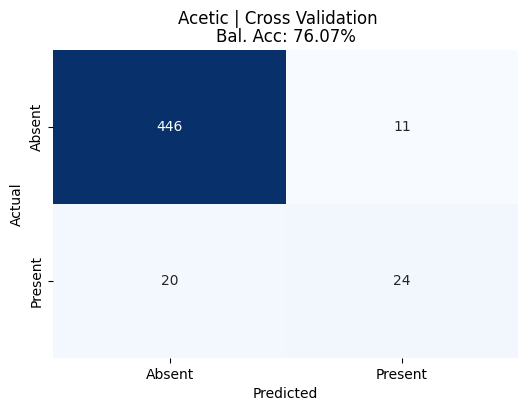

Getting cv scores for Ash


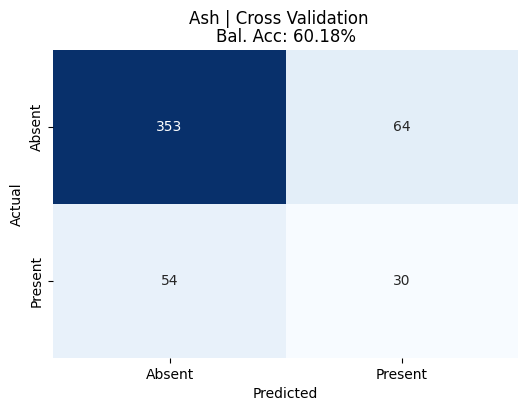

Getting cv scores for Astringent


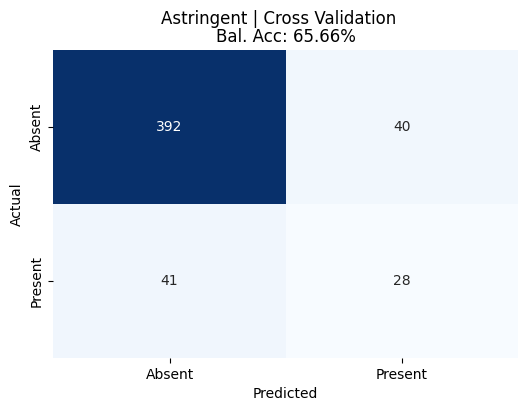

Getting cv scores for Bitter


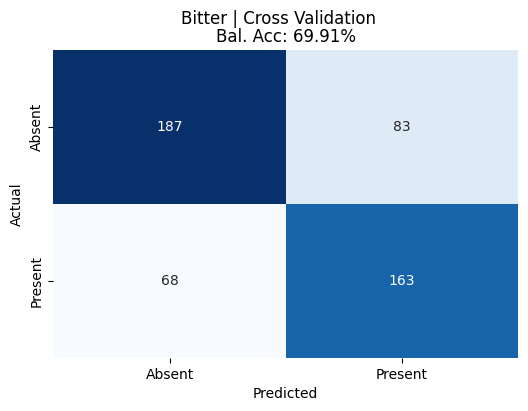

Getting cv scores for Brown Fruit


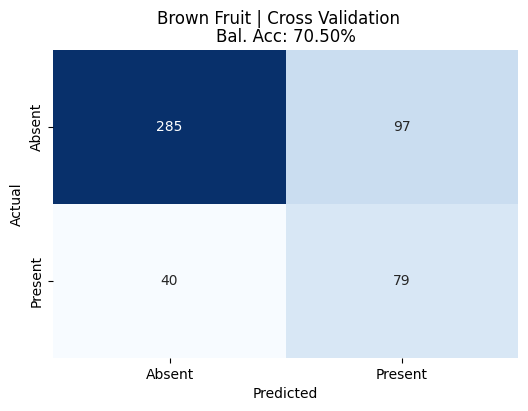

Getting cv scores for Cacao (Chocolate)


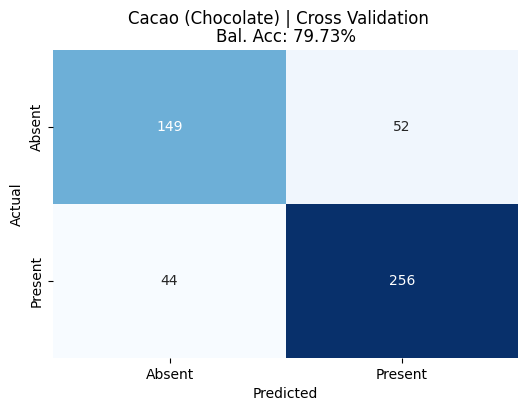

Getting cv scores for Carbon


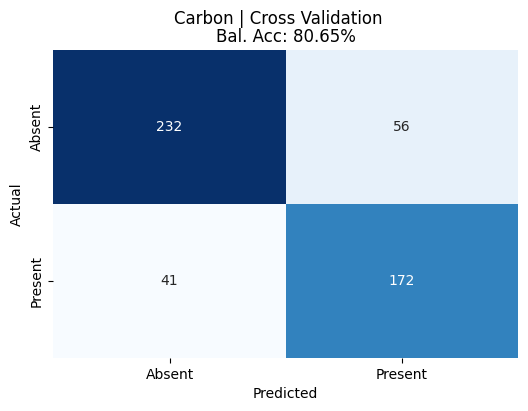

Getting cv scores for Deodorization Level


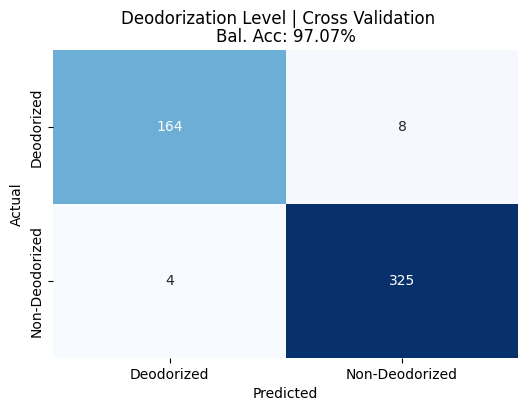

Getting cv scores for Earthy


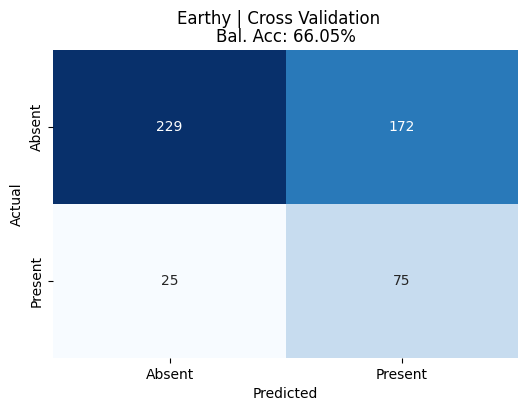

Getting cv scores for Fishy


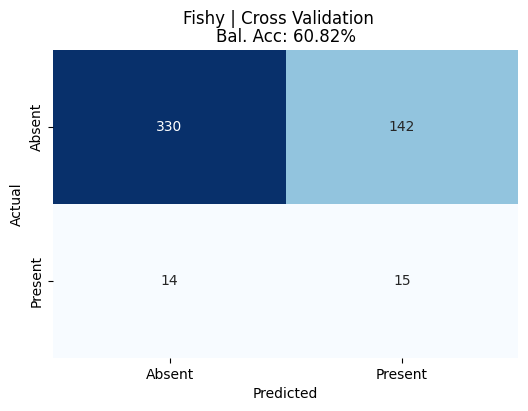

Getting cv scores for Heated Fat (Oil)


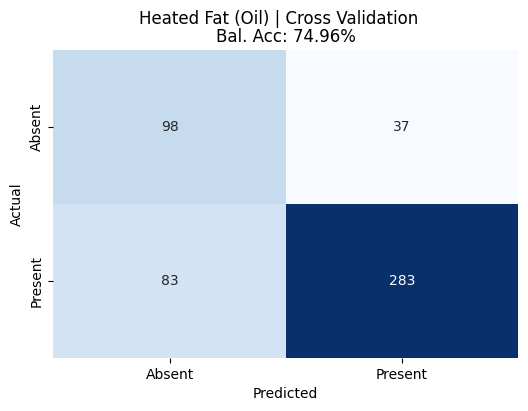

Getting cv scores for Musty


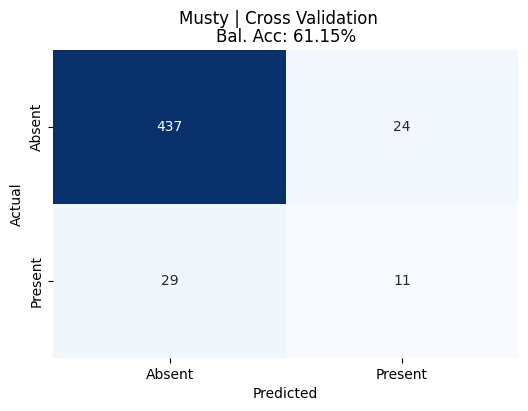

Getting cv scores for Oxidized (Old Butter-Stale-Cardboard)


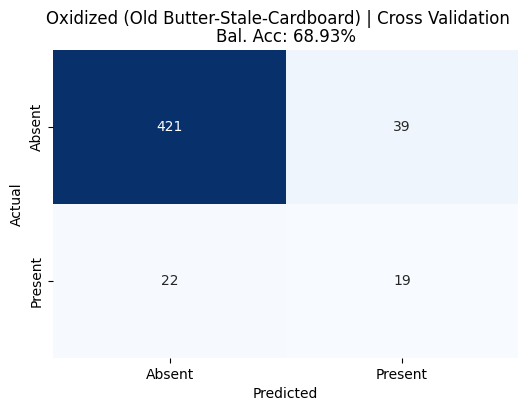

Getting cv scores for Painty (Solvent-Chemical)


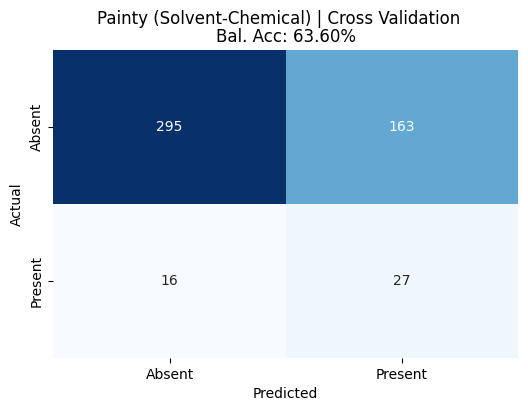

Getting cv scores for Petroleum (Motor Oil-Rubber)


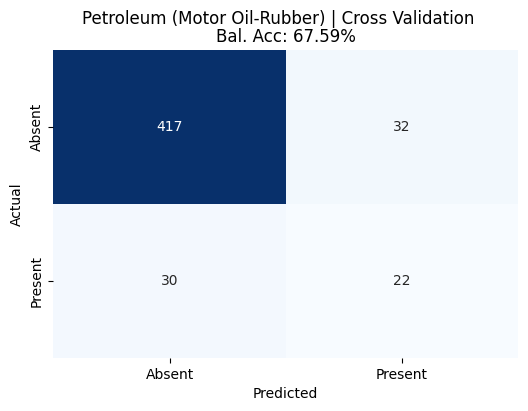

Getting cv scores for Putrid


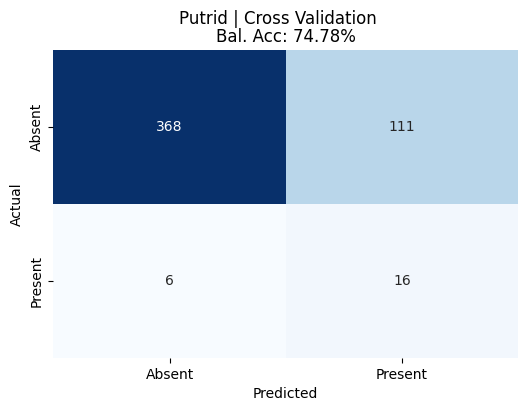

Getting cv scores for Smoky


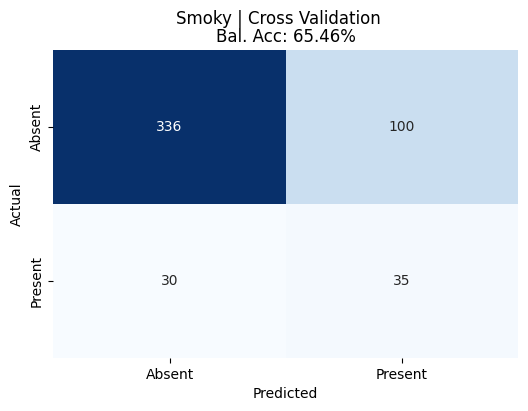

Getting cv scores for Sour


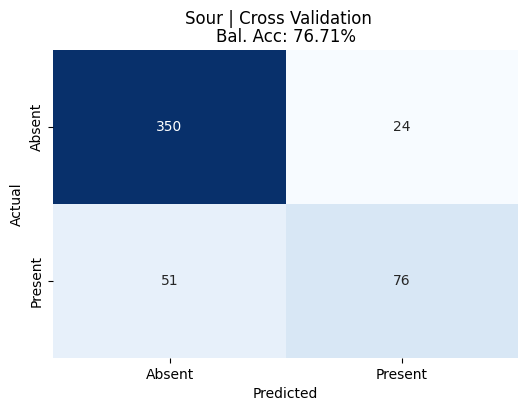

Getting cv scores for Straw (Hay)


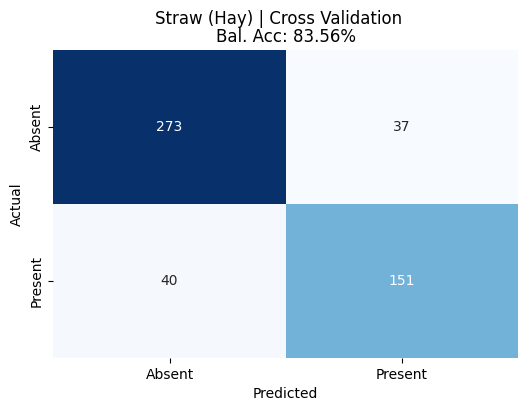

In [13]:
for col in y_train.columns:
    if y_train[col].dtype != 'object':
        continue
    print(f'Getting cv scores for {col}')
    
    output_dir = Path(f"../models/automl/{col}")
    output_dir.mkdir(parents=True, exist_ok=True)
    selected_y_train = y_train[col]

    #check if encoder exists
    if (output_dir / "encoder.pkl").exists():
        encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
        selected_y_train_encoded = pd.Series(
            encoder.transform(selected_y_train),
            index = selected_y_train.index
        )
    else:
        print("Encoder does not exist, skipping cv")

    # check if model exists
    if (output_dir / "trainer.pkl").exists():
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
    else:
        print("Model does not exist, skipping cv")

    grouped_X = X_train.groupby(X_train.index).mean()
    grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

    # Calculate CV confusion matrix
    kfold = StratifiedGroupKFold(n_splits = 3)

    grouped_cv_pred = cross_group_predict(
        trainer.get_pipeline(), 
        X = X_train,
        y = selected_y_train_encoded,
        cv = kfold,
        groups = X_train.index
    )

    cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
    bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

    fig = plt.figure(figsize = (6, 4))
    fig.suptitle(f"{col} | Cross Validation")
    ax = fig.add_subplot(111)

    ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

    cnfm_settings = {
        "cmap": "Blues",
        "cbar": None,
        "annot": True,
        "fmt": ".0f",
        "xticklabels": encoder.classes_,
        "yticklabels": encoder.classes_,
    }

    sns.heatmap(
        cnfm,
        ax = ax,
        **cnfm_settings
    )

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # plt.tight_layout()
    plt.bbox_inches = "tight"
    plt.savefig(output_dir / "cv_metrics.png")
    plt.show()
    plt.close()

# blinds predict

In [9]:
y_test.columns

Index(['Acetic', 'Ash', 'Astringent', 'Bitter', 'Brown Fruit',
       'Cacao (Chocolate)', 'Carbon', 'Deodorization Level', 'Earthy', 'Fishy',
       'Heated Fat (Oil)', 'Musty', 'Oxidized (Old Butter-Stale-Cardboard)',
       'Painty (Solvent-Chemical)', 'Petroleum (Motor Oil-Rubber)', 'Putrid',
       'Smoky', 'Sour', 'Straw (Hay)', 'Sensory Value'],
      dtype='object')

Getting test scores for Acetic


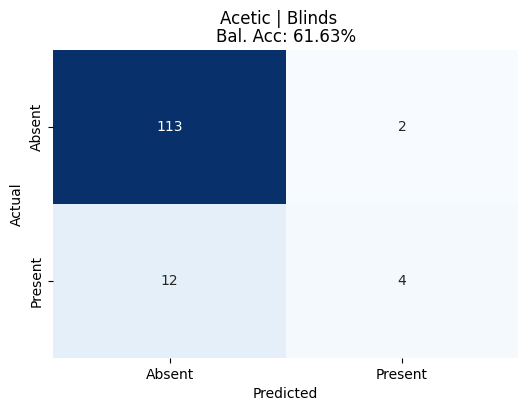

Getting test scores for Ash


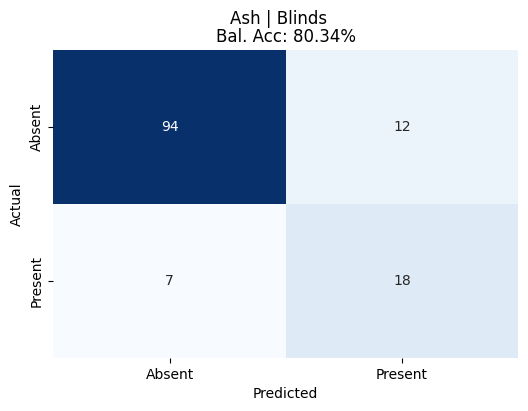

Getting test scores for Astringent


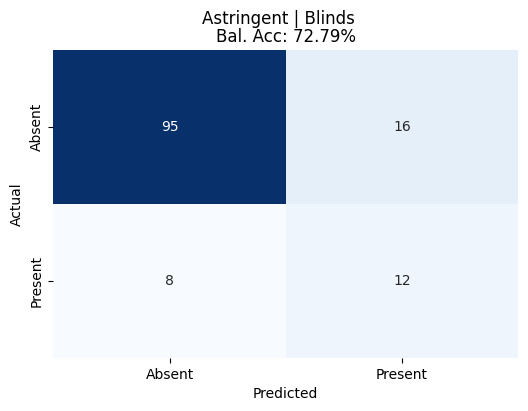

Getting test scores for Bitter


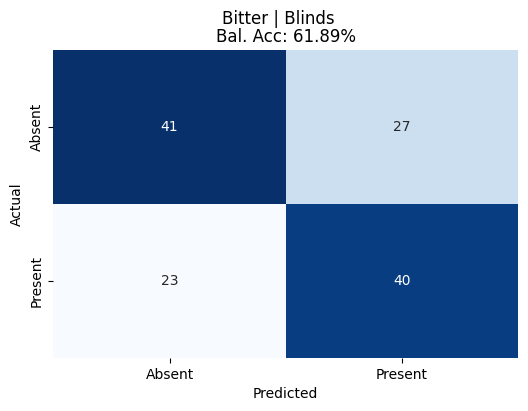

Getting test scores for Brown Fruit


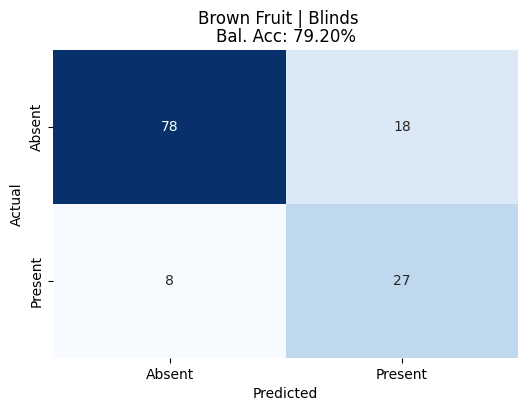

Getting test scores for Cacao (Chocolate)


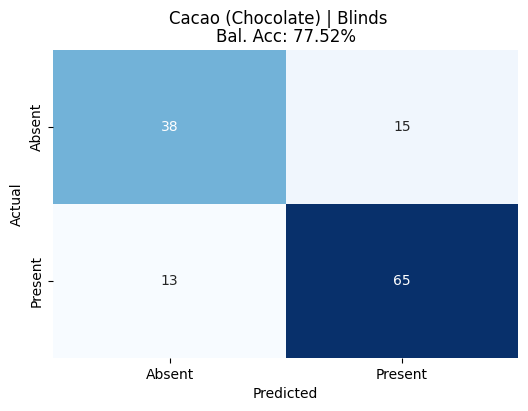

Getting test scores for Carbon


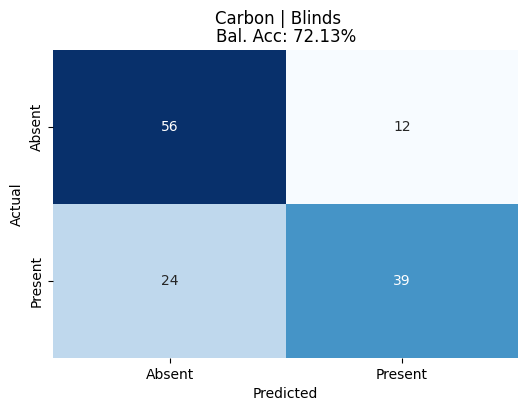

Getting test scores for Deodorization Level


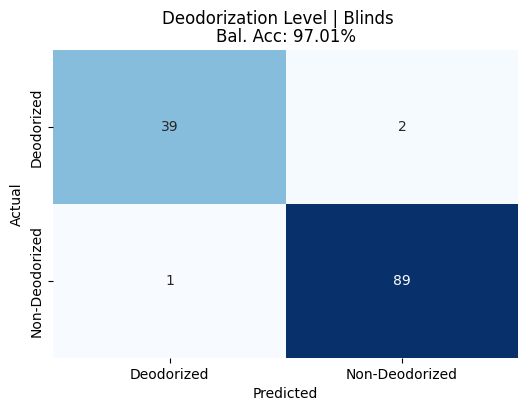

Getting test scores for Earthy


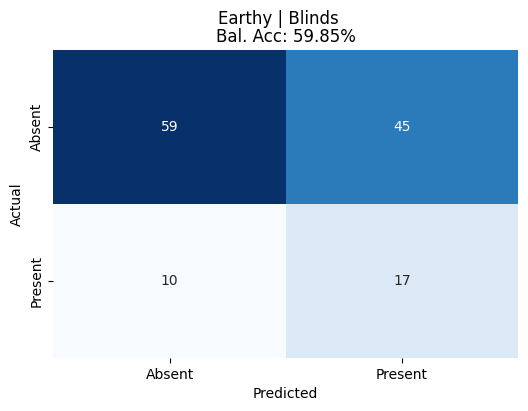

Getting test scores for Fishy


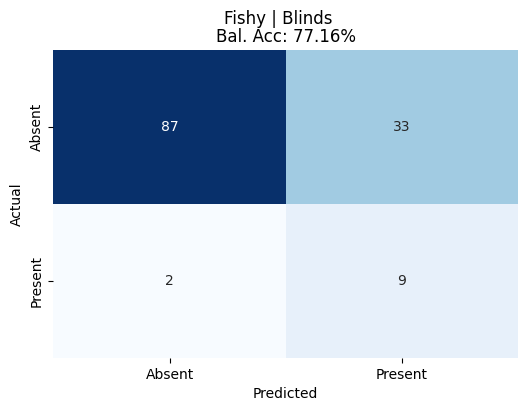

Getting test scores for Heated Fat (Oil)


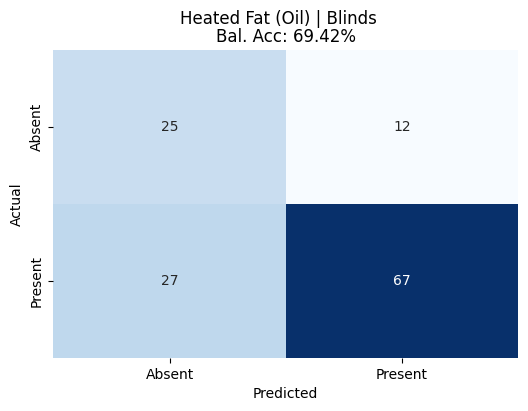

Getting test scores for Musty


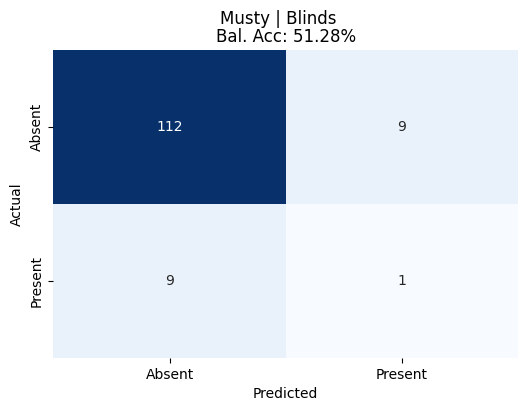

Getting test scores for Oxidized (Old Butter-Stale-Cardboard)


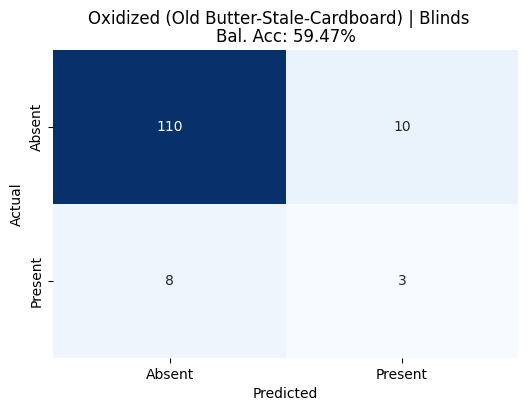

Getting test scores for Painty (Solvent-Chemical)


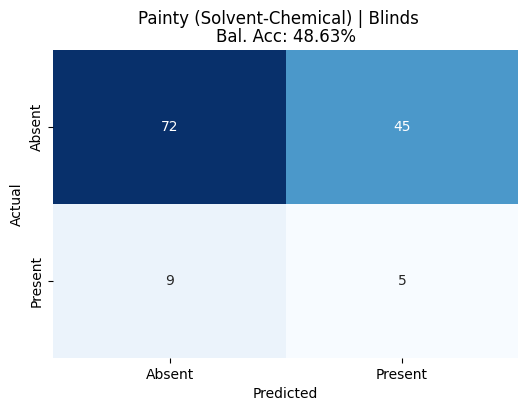

Getting test scores for Petroleum (Motor Oil-Rubber)


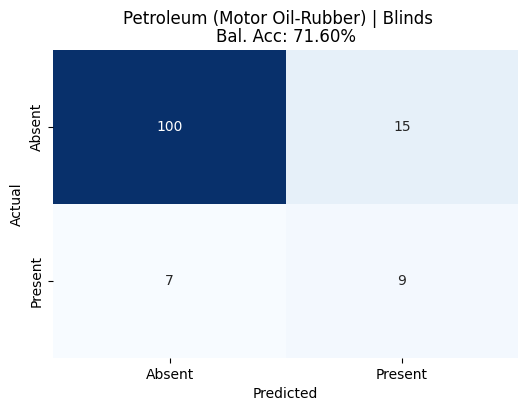

Getting test scores for Putrid


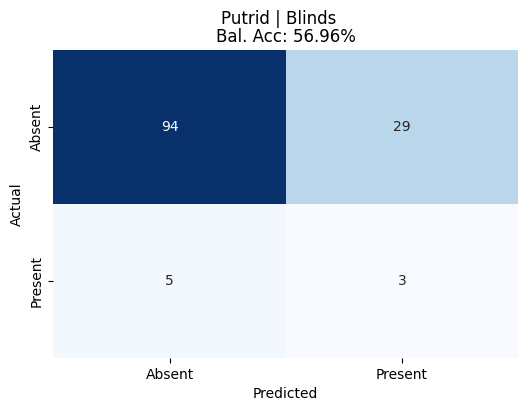

Getting test scores for Smoky


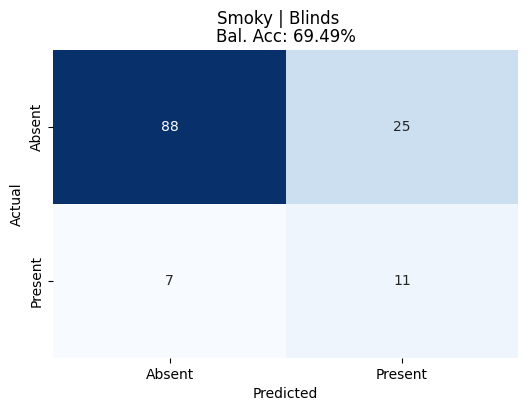

Getting test scores for Sour


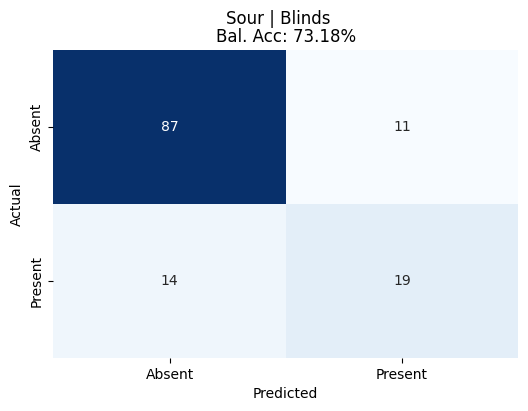

Getting test scores for Straw (Hay)


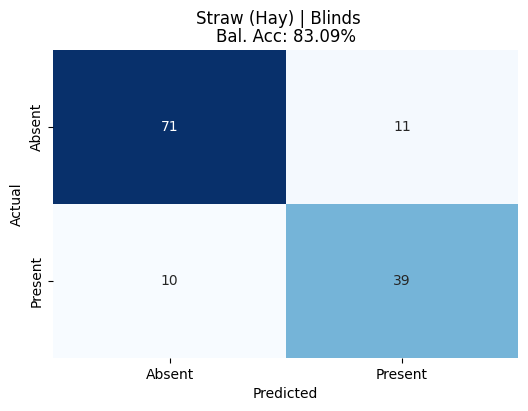

In [15]:
for col in y_test.columns:
    if y_test[col].dtype != 'object':
        continue
    print(f'Getting test scores for {col}')
    
    output_dir = Path(f"../models/automl/{col}")
    output_dir.mkdir(parents=True, exist_ok=True)
    selected_y_test = y_test[col]

    #check if encoder exists
    if (output_dir / "encoder.pkl").exists():
        encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
        selected_y_test_encoded = pd.Series(
            encoder.transform(selected_y_test),
            index = selected_y_test.index
        )
    else:
        print("Encoder does not exist, skipping test")

    # check if model exists
    if (output_dir / "trainer.pkl").exists():
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
    else:
        print("Model does not exist, skipping test")

    grouped_X_test = X_test.groupby(X_test.index).mean()
    grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

    val_pred = trainer.predict(grouped_X_test)

    cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
    bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

    fig = plt.figure(figsize = (6, 4))
    fig.suptitle(f"{col} | Blinds")
    ax = fig.add_subplot(111)

    ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

    cnfm_settings = {
        "cmap": "Blues",
        "cbar": None,
        "annot": True,
        "fmt": ".0f",
        "xticklabels": encoder.classes_,
        "yticklabels": encoder.classes_,
    }

    sns.heatmap(
        cnfm,
        ax = ax,
        **cnfm_settings
    )

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # plt.tight_layout()
    plt.bbox_inches = "tight"
    plt.savefig(output_dir / "blinds_metrics.png")
    plt.show()
    plt.close()